In [1]:
import tensorflow as tf
from tensorflow import tensordot, expand_dims
from tensorflow.keras import layers, Model, initializers, regularizers, activations, constraints, Input

from tensorflow.keras.backend import expand_dims, repeat_elements, sum
import os

Init Plugin
Init Graph Optimizer
Init Kernel


In [2]:
class MMoE(tf.keras.Model):
    '''
    @param units MMoE隐藏层单元数
    @param num_experts MMoE专家数
    @param num_tasks 下游任务数
    @param use_expert_bias 是否用expert的bias
    @param use_gate_bias 是否用用gate的bias
    @param expert_activation expert的激活函数
    @param gate_activation gated的激活函数
    @param expert_bias_initializer expert bias的初始化函数
    @param gate_bias_initializer gate bias的初始化函数
    @param expert_bias_regularizer expert bias的正则化方式
    @param gate_bias_regularizer gate bias的正则化方式
    @param expert_bias_constraint expert bias的约束
    @param gate_bias_constraint gate bias的约束
    @param expert_kernel_initializer expert权重初始化
    @param gate_kernel_initializer gate权重初始化
    @param expert_kernel_regularizer expert权重正则化
    @param gate_kernel_regularizer gate权重正则化
    @param expert_kernel_constraint expert权重约束
    @param gate_kernel_constraint gate权重约束
    @param activity_regularizery activate正则化函数
    @param kwargs Layer类附加参数
    '''
    def __init__(self, units, num_experts, num_tasks, 
                 use_expert_bias=True,use_gate_bias=True,expert_activation='relu', gate_activation='softmax',
                 expert_bias_initializer='zeros',gate_bias_initializer='zeros',expert_bias_regularizer=None, 
                 gate_bias_regularizer=None, expert_bias_constraint=None,gate_bias_constraint=None,
                 expert_kernel_initializer='VarianceScaling', gate_kernel_initializer='VarianceScaling',
                 expert_kernel_regularizer=None,gate_kernel_regularizer=None,expert_kernel_constraint=None,
                 gate_kernel_constraint=None,activity_regularizer=None, **kwargs):
        super(MMoE, self).__init__(**kwargs)
        
        self.units = units
        self.num_experts = num_experts
        self.num_tasks = num_tasks

        # Weight parameter，初始化权重
        self.expert_kernels = None
        self.gate_kernels = None
        self.expert_kernel_initializer = initializers.get(expert_kernel_initializer)
        self.gate_kernel_initializer = initializers.get(gate_kernel_initializer)
        self.expert_kernel_regularizer = regularizers.get(expert_kernel_regularizer)
        self.gate_kernel_regularizer = regularizers.get(gate_kernel_regularizer)
        self.expert_kernel_constraint = constraints.get(expert_kernel_constraint)
        self.gate_kernel_constraint = constraints.get(gate_kernel_constraint)

        # Activation parameter
        #self.expert_activation = activations.get(expert_activation)
        self.expert_activation = expert_activation
        self.gate_activation = gate_activation

        # Bias parameter，初始化偏置
        self.expert_bias = None
        self.gate_bias = None
        self.use_expert_bias = use_expert_bias
        self.use_gate_bias = use_gate_bias
        self.expert_bias_initializer = initializers.get(expert_bias_initializer)
        self.gate_bias_initializer = initializers.get(gate_bias_initializer)
        self.expert_bias_regularizer = regularizers.get(expert_bias_regularizer)
        self.gate_bias_regularizer = regularizers.get(gate_bias_regularizer)
        self.expert_bias_constraint = constraints.get(expert_bias_constraint)
        self.gate_bias_constraint = constraints.get(gate_bias_constraint)

        # Activity parameter
        self.activity_regularizer = regularizers.get(activity_regularizer)
        
        self.expert_layers = []
        self.gate_layers = []
        
        for i in range(self.num_experts):
            self.expert_layers.append(layers.Dense(self.units, activation=self.expert_activation,
                                                   use_bias=self.use_expert_bias,
                                                   kernel_initializer=self.expert_kernel_initializer,
                                                   bias_initializer=self.expert_bias_initializer,
                                                   kernel_regularizer=self.expert_kernel_regularizer,
                                                   bias_regularizer=self.expert_bias_regularizer,
                                                   activity_regularizer=None,
                                                   kernel_constraint=self.expert_kernel_constraint,
                                                   bias_constraint=self.expert_bias_constraint))
        for i in range(self.num_tasks):##两个任务输出
            self.gate_layers.append(layers.Dense(self.num_experts, activation=self.gate_activation,
                                                 use_bias=self.use_gate_bias,
                                                 kernel_initializer=self.gate_kernel_initializer,
                                                 bias_initializer=self.gate_bias_initializer,
                                                 kernel_regularizer=self.gate_kernel_regularizer,
                                                 bias_regularizer=self.gate_bias_regularizer, activity_regularizer=None,
                                                 kernel_constraint=self.gate_kernel_constraint,
                                                 bias_constraint=self.gate_bias_constraint))
        self.Dropout = layers.Dropout(0.5)
    def call(self, inputs):
        expert_outputs, gate_outputs, final_outputs = [], [], []
        for expert_layer in self.expert_layers:
            expert_output = expand_dims(expert_layer(inputs), axis=2)
            #print(expert_output.shape)
            expert_outputs.append(expert_output)
        expert_outputs = tf.concat(expert_outputs,2)
        #print(expert_outputs.shape)
        
        for gate_layer in self.gate_layers:
            gate_outputs.append(self.Dropout(gate_layer(inputs)))
            
        for gate_output in gate_outputs:
            #print('Gate Ouput')
            #print(gate_output.shape)
            expanded_gate_output = expand_dims(gate_output, axis=1)##左右两边的任务输出
            #print(expanded_gate_output.shape)
            weighted_expert_output = expert_outputs * repeat_elements(expanded_gate_output, self.units, axis=1)##专家网络输出与
                                                                                                            #task输出权重加权平均
            #print(weighted_expert_output.shape)
            final_outputs.append(sum(weighted_expert_output, axis=2))
        return final_outputs



In [3]:
input_layers = layers.Input(shape=(499,))
mmoe_layer = MMoE(units=4, num_experts=8, num_tasks=2)(input_layers)

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2024-01-07 13:40:35.487641: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-07 13:40:35.488268: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
output_layers = []
for index, task_layer in enumerate(mmoe_layer):
    tower_layer = layers.Dense(units=8, activation='relu', kernel_initializer=tf.keras.initializers.VarianceScaling())(task_layer)
    output_layer = layers.Dense(units=2, name=str(index), activation='softmax', kernel_initializer=tf.keras.initializers.VarianceScaling())(tower_layer)
    output_layers.append(output_layer)

In [5]:
model = tf.keras.Model(inputs=[input_layers], outputs=output_layers)

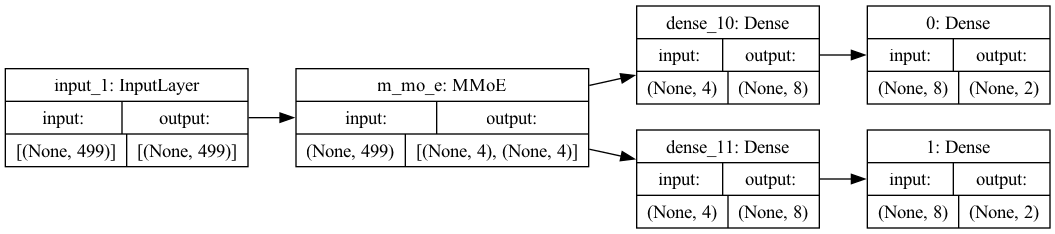

In [6]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [6]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 499)]        0                                            
__________________________________________________________________________________________________
m_mo_e (MMoE)                   [(None, 4), (None, 4 24000       input_1[0][0]                    
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 8)            40          m_mo_e[0][0]                     
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 8)            40          m_mo_e[0][1]                     
______________________________________________________________________________________________

In [7]:
import numpy as np
'''
    将csv数据每一行转换为特征值和标签值
    @param line line
    @param n_feature 特征纬度
    @return x 特征
    @return y 标签
'''
def parse_csv_line(line, n_feature=503):
    defs = [tf.constant(np.nan)] * n_feature
    parsed_field = tf.io.decode_csv(line, record_defaults=defs)
    x = tf.stack(parsed_field[0:-4])
    y_income = tf.stack(parsed_field[-4:-2])
    y_marital = tf.stack(parsed_field[-2:])
    return x, (y_income, y_marital)

In [10]:
'''
    将csv文件列表处理为TFDataSet
    @param filenames csv文件名列表
    @param n_reader interleave cycle_length
    @param batch_size batch_size
    @param n_parse_threads map的并行数
    @param shuffle_buffer_size shuffer_size
    @return dataset TFDataset
'''
def csv_reader_dataset(filenames, n_readers=5, batch_size=32, n_parse_threads=5, shuffle_buffer_size=10000):
    dataset = tf.data.Dataset.list_files(filenames)
    dataset = dataset.interleave(
        lambda filename : tf.data.TextLineDataset(filename),
        cycle_length=n_readers
    )
    dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(parse_csv_line, num_parallel_calls=n_parse_threads)
    dataset = dataset.batch(batch_size)
    return dataset

In [11]:
metrics = [
            tf.keras.metrics.TruePositives(name='tp'),
            tf.keras.metrics.FalsePositives(name='fp'),
            tf.keras.metrics.TrueNegatives(name='tn'),
            tf.keras.metrics.FalseNegatives(name='fn'),
            tf.keras.metrics.BinaryAccuracy(name='accuracy'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='auc'),
            tf.keras.metrics.AUC(name='prauc',curve='PR')
        ]
model.compile(
    loss={'income':'binary_crossentropy','marital':'binary_crossentropy'},
    optimizer=tf.keras.optimizers.Adam(),
    metrics=metrics,
    experimental_run_tf_function=False
)

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 499)]        0                                            
__________________________________________________________________________________________________
m_mo_e (MMoE)                   [(None, 4), (None, 4 24000       input_1[0][0]                    
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 8)            40          m_mo_e[0][0]                     
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 8)            40          m_mo_e[0][1]                     
______________________________________________________________________________________________